# Deep Residual Learning For Image Recognition

Some jargons I'm not familiar with when first reading. I will explain them in detail later on.

The whole passage will include two main parts:
1. **Classification tasks on CIFAR-10**
2. **Object Detection on PASCAL and MS COCO**

In [1]:
#notebook setup
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.datasets as dset

import numpy as np
import sys
import time
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

And also some useful function:

In [2]:
def show_images(imgs):
    NUM = imgs.shape[0]
    
    sqrtn = int(np.ceil(np.sqrt(NUM)))
    sqrtimg = int(np.ceil(np.sqrt(NUM)))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(imgs):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img)
    return


term_width = int(5)

TOTAL_BAR_LENGTH = 65.
last_time = time.time()
begin_time = last_time

#https://stackoverflow.com/questions/10019456/usage-of-sys-stdout-flush-method
def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current+1, total))

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()
    
def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f

## Classification tasks on CIFAR-10

First we need to download the data if needed. And then preprocess as following:

1. 4 pixels padding and random cropping
2. flipping randomly
3. normalize

***

The intuition behind them are explained [here](https://stackoverflow.com/questions/32842308/random-cropping-and-flipping-in-convolutional-neural-networks/32844299):

>This is referred to as **data augmentation**. By applying transformations to the training data, you're adding synthetic data points. This exposes the model to additional variations without the cost of collecting and annotating more data. This can have the effect of reducing overfitting and improving the model's ability to generalize.

>The intuition behind **flipping** an image is that an object should be equally recognizable as its mirror image. Note that horizontal flipping is the type of flipping often used. Vertical flipping doesn't always make sense but this depends on the data.

>The idea behind **cropping** is that to reduce the contribution of the background in the CNNs decision. That's useful if you have labels for locating where your object is. This lets you use surrounding regions as negative examples and building a better detector. Random cropping can also act as a regularizer and base your classification on the presence of parts of the object *instead of focusing everything on a very distinct feature* that may not always be present.

And a very approaching idea on random cropping:

>I think random cropping also associate a broader range of spatial activation statistics with a certain class label and thus makes the algorithm more robust.

***

Some tips here:
1. just mentioned CIFAR in PyTorch will load all data into memory at the beginning, not to large.
2. T.ToTensor will convert img in the range [0,255] to that in [0,1]. Some codes Normalize them using (0.5,0.5,0.5) to rescale it to range(-1,1) after ToTensor operation.

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


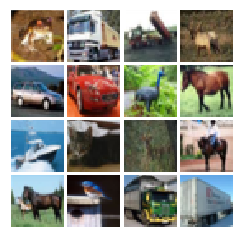

In [3]:
# size of the image dataset N * 32 * 32 * 3
NUM_TRAIN = 45000
NUM_VAL = 5000


train_CIFAR = dset.CIFAR10('../datasets/', train=True, download=True)
train_mean = np.mean(train_CIFAR.train_data, axis=(0,1,2))/255
train_std = np.std(train_CIFAR.train_data, axis=(0,1,2))/255

train_transform = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(train_mean, train_std)
])

test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(train_mean, train_std)
])
train_CIFAR = dset.CIFAR10('../datasets/', train=True, download=True, transform = train_transform)
train_loader = DataLoader(train_CIFAR, batch_size = 128, num_workers=2, 
                          sampler= SubsetRandomSampler(list(range(NUM_TRAIN))))
val_loader = DataLoader(train_CIFAR, batch_size = 128, num_workers=2, 
                          sampler= SubsetRandomSampler(list(range(NUM_TRAIN,(NUM_TRAIN+NUM_VAL)))))

test_CIFAR = dset.CIFAR10('../datasets/', train=False, download=True, transform= T.ToTensor())
test_loader = DataLoader(test_CIFAR, batch_size = 128, num_workers=2, shuffle=False)

NUM_SHOW = 16

img =train_CIFAR.train_data[:NUM_SHOW,:]
show_images(img)

Then we will import Resnet-20, 32 and so on to train it on the training data.

In [ ]:
from resnet import Resnet20
res20 = Resnet20()

learning_rate=0.1
weight_decay = 0.0001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(res20.parameters(), lr=learning_rate,weight_decay=weight_decay)

In [ ]:
def train(epoch):
    loss_hist = []
    for i in range(epoch):
        print('This is epoch:{}'.format(i+1))
        total= 0
        correct=0
        for j,(batch_x, batch_y) in enumerate(train_loader):
            res20.train()
            x = Variable(batch_x)
            y = Variable(batch_y)
            out = res20(x)
            loss = criterion(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(out.data, 1)
            total += y.size(0)
            correct += predicted.eq(y.data).cpu().sum()
            
            loss_hist.append(loss.data[0])
            test(res20, val_loader)
            progress_bar(j, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (loss.data[0], 100.*correct/total, correct, total))
        if i %1 == 0:
            acc = test(res20, val_loader)
            print('Epoch {}, loss: {}, accuracy: {}'.format(i+1, loss_hist[-1], acc))
            acc = test(res20, test_loader)
            print('Epoch {}, loss: {}, accuracy: {}'.format(i+1, loss_hist[-1], acc))
                
def test(model, val_load):
    model.eval()
    total = 0
    positive = 0
    for val_x, val_y in val_load:
        x = Variable(val_x)
        y = Variable(val_y)
        out = model(x)
        #print(out.size())
        positive += (torch.max(out,1)[1]==y).sum().data[0]
        total += out.size()[0]
    acc =  (positive*1.0)/total
    return acc 

train(200)

This is epoch:1
 [================================================================>]  Step: 11s746ms | Tot: 1h9m | Loss: 1.904 | Acc: 20.762% (9343/45000) 352/352   2 
Epoch 1, loss: 1.9040881395339966, accuracy: 0.1404
Epoch 1, loss: 1.9040881395339966, accuracy: 0.1112
This is epoch:2
 [================================================================>]  Step: 11s336ms | Tot: 1h8m | Loss: 1.976 | Acc: 22.376% (10069/45000) 352/352 2  
Epoch 2, loss: 1.9759856462478638, accuracy: 0.1476
Epoch 2, loss: 1.9759856462478638, accuracy: 0.1008
This is epoch:3
 [================================================================>]  Step: 24s241ms | Tot: 1h21m | Loss: 2.094 | Acc: 22.924% (10316/45000) 352/352 2 
Epoch 3, loss: 2.09397029876709, accuracy: 0.115
Epoch 3, loss: 2.09397029876709, accuracy: 0.1596
This is epoch:4
 [================================================================>]  Step: 40s255ms | Tot: 4h13m | Loss: 1.902 | Acc: 25.511% (11480/45000) 352/352  
Epoch 4, loss: 1.90165